GRP into python
  * Read Data
  * Calculate Signal for each strategy (Complete list: )
    * TS
    * CS
  * Backtesting ( 'Factor' in GRP )
    * TS
    * CS
  

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd

# Read Data

In [4]:
# DM Equity data
# read data from csv file
total_ret_idx = pd.read_csv('./data/totindex.csv', header=0, index_col=0, parse_dates=True)
total_ret = total_ret_idx.pct_change(1)
prc_idx = pd.read_csv('./data/priceindex.csv', header=0, index_col=0, parse_dates=True)
prc_ret = prc_idx.pct_change(1)
fut_idx = pd.read_csv('./data/FutGenratio1.csv', header=0, index_col=0, parse_dates=True)
fut_ret = fut_idx.pct_change(1)

# add price return to any NA row of total return DataFrame
no_data_dates = total_ret[(total_ret.isnull().sum(axis=1) > 0).values].index
total_ret.loc[no_data_dates] = prc_ret.loc[no_data_dates]
# Make ERet by below rule
ERet = pd.concat([total_ret.loc[:'2007-12-31'], fut_ret.loc['2008-01-01':]], axis=0)
ERet.fillna(0, inplace=True)

Eindex = (1. + ERet).cumprod()

FileNotFoundError: [Errno 2] File b'./data/totindex.csv' does not exist: b'./data/totindex.csv'

# Calculate Signal

# EPM
** Equity Price Momentum전략 **
여러가지 모멘텀 전략이 합쳐져 있는 전략. 전략의 종류는 4가지
1. Long-Term 모멘텀: TS 전략에만 적용하며 52주-2주 & 2주 Shift로 + 일때 롱
2. Shot-Term 모멘텀: TS 전략에만 적용하며 13주-2주 & 2주 Shift로 + 일때 롱
3. Shot-Term Reversal: CS 전략에만 적용하며 1주, 4주 수익률 순위의 역순으로 나쁜 지수를 롱, 좋은 지수를 숏.
4. EPS 모멘텀과 가격 모멘텀의 비교: CS 전략에만 적용하며 EPS의 1개월 변동률을 1개월 가격 변동률로 뺀 숫자가 높을 수록 롱, 낮을 수록 숏.

총 인덱스 갯수는 14개 인데 이중 아시아 관련 4개를 따로 빼서 Cross Sectional을 하고 나머지 10개에 대해서 Cross Sectional을 따로 함. 이유는 걍 지시 사항이였다고.

이게 너무 여러 시그널이 겹쳐있어서 각각의 시그널에 대해서 확인할 필요가 있을 듯.

Notes. 

In [4]:
# EPM - weekly
# Param Settings
RET = ERet
index = Eindex

minobs1 = 52 
minobs = 260
longlen = 52 # lookback period for calculating momentum
shortlen = 2 # lookback period for calculating revsersal & exclude period for momentum
nopos = 0.4 # no position zone in the middle of two extreme
#
SDEV = 12 # what's this?

WGT = [1./3., 1./3., 1./3.] # what's this?
CS = 0.35 # Percent of positions for Cross Sectional Signal
RB = 1 # rebalancing weekday

index = index[index.index.weekday == RB] # index to weekly
# Making Signal
# Signal1. Momentum
# Time Series
Mag = index.pct_change(longlen - shortlen).shift(shortlen).iloc[minobs1:]
TS_lm = Mag * 0.
TS_lm[Mag > 0.] = 1.
TS_lm[Mag < 0.] = -1.

# Cross Sectional
truecount_lower = (Mag.notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
truecount_upper = Mag.notnull().sum(axis=1) - truecount_lower

CSRV = Mag.rank(axis=1)
CSRV[CSRV.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
CSRV[CSRV.apply(lambda x: x > truecount_upper, axis=0)] = 1.

CSRV_lm = CSRV.applymap(lambda x: x if x == 1. or x == -1. else 0.)

# Signal2. Pecentage of up days
# Time Series
up = ERet.applymap(lambda x: 1 if x > 0 else 0)
conroll = up.rolling(longlen - shortlen).sum().shift(shortlen).iloc[minobs1:] / (longlen - shortlen)

TS_lu = conroll * 0.
TS_lu[conroll > 0.5] = 1.
TS_lu[conroll < 0.5] = -1.

# Cross Sectional
truecount_lower = (conroll.notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
truecount_upper = conroll.notnull().sum(axis=1) - truecount_lower

CSRV = conroll.rank(axis=1)
CSRV[CSRV.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
CSRV[CSRV.apply(lambda x: x > truecount_upper, axis=0)] = 1.

CSRV_lu = CSRV.applymap(lambda x: x if x == 1. or x == -1. else 0.)

# Signal3. Short-term momentum - only for Time Series
longlen = 13 # change param
# Time Series
Mag = index.pct_change(longlen - shortlen).shift(shortlen).iloc[minobs1:]
TS_sm = Mag * 0.
TS_sm[Mag > 0.] = 1.
TS_sm[Mag < 0.] = -1.

# Signal4. Pecentage of up days - short-term momentum - only for Time Series
# Time Series
up = ERet.applymap(lambda x: 1 if x > 0 else 0)
conroll = up.rolling(longlen - shortlen).sum().shift(shortlen).iloc[minobs1:] / (longlen - shortlen)

TS_su = conroll * 0.
TS_su[conroll > 0.5] = 1.
TS_su[conroll < 0.5] = -1.

# Signal5. Short-term reversal, only for cross sectional
# 4 weeks
Mag = -1*index.pct_change(4).iloc[minobs1:]

# Cross Sectional
truecount_lower = (Mag.notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
truecount_upper = Mag.notnull().sum(axis=1) - truecount_lower

CSRV = Mag.rank(axis=1)
CSRV[CSRV.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
CSRV[CSRV.apply(lambda x: x > truecount_upper, axis=0)] = 1.

CSRV_sr = CSRV.applymap(lambda x: x if x == 1. or x == -1. else 0.)

# 1weeks
Mag = -1*index.pct_change(1).iloc[minobs1:]

# Cross Sectional
truecount_lower = (Mag.notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
truecount_upper = Mag.notnull().sum(axis=1) - truecount_lower

CSRV = Mag.rank(axis=1)
CSRV[CSRV.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
CSRV[CSRV.apply(lambda x: x > truecount_upper, axis=0)] = 1.

CSRV_sr2 = CSRV.applymap(lambda x: x if x == 1. or x == -1. else 0.)

# Signal 6. EPS 1 month momentum  - Price 1 month momentum. - only for CS
eps = pd.read_csv('./data/eps.csv', header=0, index_col=0, parse_dates=True)
indexmon = Eindex.loc[eps.index]
Mag = eps.pct_change() - indexmon.pct_change()

# Cross Sectional
truecount_lower = (Mag.notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
truecount_upper = Mag.notnull().sum(axis=1) - truecount_lower

CSRV = Mag.rank(axis=1)
CSRV[CSRV.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
CSRV[CSRV.apply(lambda x: x > truecount_upper, axis=0)] = 1.

CSRV_eps_rel = CSRV.applymap(lambda x: x if x == 1. or x == -1. else 0.)

# combining signals
TSRVL = TS_lm*1./3. + TS_lu*1./3.
TSRVS = TS_sm*1./3. + TS_su*1./3.
TSRV = TSRVS*0.5 + TSRVL

CSRVL = CSRV_lm*1./3. + CSRV_lu*1./3.
CSRVS = CSRV_sr*0.5 + CSRV_sr2
CSRV = CSRVS*0.5 + CSRV_eps_rel.loc[CSRVS.index].fillna(method='ffill')

# Align dates with Return DataFrame
TSRV = TSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')
CSRV = CSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')

# Align dates with each other
if TSRV.index[0] > CSRV.index[0]:
    CSRV = CSRV.loc[TSRV.index[0]:]
else:
    TSRV = TSRV.loc[CSRV.index[0]:]

min_vol = 0.15
freq = 'week'

## EPM - long term momentum only

In [9]:
# EPM - weekly
# Param Settings
RET = ERet
index = Eindex

minobs1 = 52 
minobs = 260
longlen = 52 # lookback period for calculating momentum
shortlen = 2 # lookback period for calculating revsersal & exclude period for momentum
nopos = 0.4 # no position zone in the middle of two extreme
#
SDEV = 12 # what's this?

WGT = [1./3., 1./3., 1./3.] # what's this?
CS = 0.35 # Percent of positions for Cross Sectional Signal
RB = 1 # rebalancing weekday

index = index[index.index.weekday == RB] # index to weekly
# Making Signal
# Signal1. Momentum
# Time Series
Mag = index.pct_change(longlen - shortlen).shift(shortlen).iloc[minobs1:]
TS_lm = Mag * 0.
TS_lm[Mag > 0.] = 1.
TS_lm[Mag < 0.] = -1.

# Cross Sectional
truecount_lower = (Mag.notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
truecount_upper = Mag.notnull().sum(axis=1) - truecount_lower

CSRV = Mag.rank(axis=1)
CSRV[CSRV.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
CSRV[CSRV.apply(lambda x: x > truecount_upper, axis=0)] = 1.

CSRV_lm = CSRV.applymap(lambda x: x if x == 1. or x == -1. else 0.)

# combining signals
TSRV = TS_lm

CSRV = CSRV_lm

# Align dates with Return DataFrame
TSRV = TSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')
CSRV = CSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')

# Align dates with each other
if TSRV.index[0] > CSRV.index[0]:
    CSRV = CSRV.loc[TSRV.index[0]:]
else:
    TSRV = TSRV.loc[CSRV.index[0]:]

min_vol = 0.15
freq = 'week'

## EPM - long term momentum updays only

In [4]:
# EPM - weekly
# Param Settings
RET = ERet
index = Eindex

minobs1 = 52 
minobs = 260
longlen = 52 # lookback period for calculating momentum
shortlen = 2 # lookback period for calculating revsersal & exclude period for momentum
nopos = 0.4 # no position zone in the middle of two extreme
#
SDEV = 12 # what's this?

WGT = [1./3., 1./3., 1./3.] # what's this?
CS = 0.35 # Percent of positions for Cross Sectional Signal
RB = 1 # rebalancing weekday

index = index[index.index.weekday == RB] # index to weekly
# Making Signal
# Signal2. Pecentage of up days
# Time Series
up = ERet.applymap(lambda x: 1 if x > 0 else 0)
conroll = up.rolling(longlen - shortlen).sum().shift(shortlen).iloc[minobs1:] / (longlen - shortlen)

TS_lu = conroll * 0.
TS_lu[conroll > 0.5] = 1.
TS_lu[conroll < 0.5] = -1.

# Cross Sectional
truecount_lower = (conroll.notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
truecount_upper = conroll.notnull().sum(axis=1) - truecount_lower

CSRV = conroll.rank(axis=1)
CSRV[CSRV.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
CSRV[CSRV.apply(lambda x: x > truecount_upper, axis=0)] = 1.

CSRV_lu = CSRV.applymap(lambda x: x if x == 1. or x == -1. else 0.)

# combining signals
TSRV = TS_lu

CSRV = CSRV_lu

# Align dates with Return DataFrame
TSRV = TSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')
CSRV = CSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')

# Align dates with each other
if TSRV.index[0] > CSRV.index[0]:
    CSRV = CSRV.loc[TSRV.index[0]:]
else:
    TSRV = TSRV.loc[CSRV.index[0]:]

min_vol = 0.15
freq = 'week'

## EPM - short-term momentum only

In [22]:
# EPM - weekly
# Param Settings
RET = ERet
index = Eindex

minobs1 = 52 
minobs = 260
longlen = 52 # lookback period for calculating momentum
shortlen = 2 # lookback period for calculating revsersal & exclude period for momentum
nopos = 0.4 # no position zone in the middle of two extreme
#
SDEV = 12 # what's this?

WGT = [1./3., 1./3., 1./3.] # what's this?
CS = 0.35 # Percent of positions for Cross Sectional Signal
RB = 1 # rebalancing weekday

index = index[index.index.weekday == RB] # index to weekly
# Making Signal
# Signal3. Short-term momentum - only for Time Series
longlen = 13 # change param
# Time Series
Mag = index.pct_change(longlen - shortlen).shift(shortlen).iloc[minobs1:]
TS_sm = Mag * 0.
TS_sm[Mag > 0.] = 1.
TS_sm[Mag < 0.] = -1.

# Cross Sectional
truecount_lower = (Mag.notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
truecount_upper = Mag.notnull().sum(axis=1) - truecount_lower

CSRV = Mag.rank(axis=1)
CSRV[CSRV.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
CSRV[CSRV.apply(lambda x: x > truecount_upper, axis=0)] = 1.

CSRV_sm = CSRV.applymap(lambda x: x if x == 1. or x == -1. else 0.)

# combining signals
TSRV = TS_sm

CSRV = CSRV_sm

# Align dates with Return DataFrame
TSRV = TSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')
CSRV = CSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')

# Align dates with each other
if TSRV.index[0] > CSRV.index[0]:
    CSRV = CSRV.loc[TSRV.index[0]:]
else:
    TSRV = TSRV.loc[CSRV.index[0]:]

min_vol = 0.15
freq = 'week'

## EPM short term momentum updays

In [25]:
# EPM - weekly
# Param Settings
RET = ERet
index = Eindex

minobs1 = 52 
minobs = 260
longlen = 52 # lookback period for calculating momentum
shortlen = 2 # lookback period for calculating revsersal & exclude period for momentum
nopos = 0.4 # no position zone in the middle of two extreme
#
SDEV = 12 # what's this?

WGT = [1./3., 1./3., 1./3.] # what's this?
CS = 0.35 # Percent of positions for Cross Sectional Signal
RB = 1 # rebalancing weekday

index = index[index.index.weekday == RB] # index to weekly
# Making Signal
# Signal4. Pecentage of up days - short-term momentum - only for Time Series
longlen = 13 # change param
# Time Series
up = ERet.applymap(lambda x: 1 if x > 0 else 0)
conroll = up.rolling(longlen - shortlen).sum().shift(shortlen).iloc[minobs1:] / (longlen - shortlen)

TS_su = conroll * 0.
TS_su[conroll > 0.5] = 1.
TS_su[conroll < 0.5] = -1.

# Cross Sectional
truecount_lower = (conroll.notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
truecount_upper = conroll.notnull().sum(axis=1) - truecount_lower

CSRV = conroll.rank(axis=1)
CSRV[CSRV.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
CSRV[CSRV.apply(lambda x: x > truecount_upper, axis=0)] = 1.

CSRV_su = CSRV.applymap(lambda x: x if x == 1. or x == -1. else 0.)

# combining signals
TSRV = TS_su

CSRV = CSRV_su

# Align dates with Return DataFrame
TSRV = TSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')
CSRV = CSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')

# Align dates with each other
if TSRV.index[0] > CSRV.index[0]:
    CSRV = CSRV.loc[TSRV.index[0]:]
else:
    TSRV = TSRV.loc[CSRV.index[0]:]

min_vol = 0.15
freq = 'week'

## EPS Short term reversal - 4 weeks

In [28]:
# EPM - weekly
# Param Settings
RET = ERet
index = Eindex

minobs1 = 52 
minobs = 260
longlen = 52 # lookback period for calculating momentum
shortlen = 2 # lookback period for calculating revsersal & exclude period for momentum
nopos = 0.4 # no position zone in the middle of two extreme
#
SDEV = 12 # what's this?

WGT = [1./3., 1./3., 1./3.] # what's this?
CS = 0.35 # Percent of positions for Cross Sectional Signal
RB = 1 # rebalancing weekday

index = index[index.index.weekday == RB] # index to weekly
# Making Signal
# 4 weeks
Mag = -1*index.pct_change(4).iloc[minobs1:]
# Time Series
TS_sr = Mag * 0.
TS_sr[Mag > 0.] = 1.
TS_sr[Mag < 0.] = -1.

# Cross Sectional
truecount_lower = (Mag.notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
truecount_upper = Mag.notnull().sum(axis=1) - truecount_lower

CSRV = Mag.rank(axis=1)
CSRV[CSRV.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
CSRV[CSRV.apply(lambda x: x > truecount_upper, axis=0)] = 1.

CSRV_sr = CSRV.applymap(lambda x: x if x == 1. or x == -1. else 0.)

# combining signals
TSRV = TS_sr

CSRV = CSRV_sr

# Align dates with Return DataFrame
TSRV = TSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')
CSRV = CSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')

# Align dates with each other
if TSRV.index[0] > CSRV.index[0]:
    CSRV = CSRV.loc[TSRV.index[0]:]
else:
    TSRV = TSRV.loc[CSRV.index[0]:]

min_vol = 0.15
freq = 'week'

## EPM short term reversal - 1 weeks

In [31]:
# EPM - weekly
# Param Settings
RET = ERet
index = Eindex

minobs1 = 52 
minobs = 260
longlen = 52 # lookback period for calculating momentum
shortlen = 2 # lookback period for calculating revsersal & exclude period for momentum
nopos = 0.4 # no position zone in the middle of two extreme
#
SDEV = 12 # what's this?

WGT = [1./3., 1./3., 1./3.] # what's this?
CS = 0.35 # Percent of positions for Cross Sectional Signal
RB = 1 # rebalancing weekday

index = index[index.index.weekday == RB] # index to weekly
# Making Signal
# 4 weeks
Mag = -1*index.pct_change(1).iloc[minobs1:]
# Time Series
TS_sr = Mag * 0.
TS_sr[Mag > 0.] = 1.
TS_sr[Mag < 0.] = -1.

# Cross Sectional
truecount_lower = (Mag.notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
truecount_upper = Mag.notnull().sum(axis=1) - truecount_lower

CSRV = Mag.rank(axis=1)
CSRV[CSRV.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
CSRV[CSRV.apply(lambda x: x > truecount_upper, axis=0)] = 1.

CSRV_sr = CSRV.applymap(lambda x: x if x == 1. or x == -1. else 0.)

# combining signals
TSRV = TS_sr

CSRV = CSRV_sr

# Align dates with Return DataFrame
TSRV = TSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')
CSRV = CSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')

# Align dates with each other
if TSRV.index[0] > CSRV.index[0]:
    CSRV = CSRV.loc[TSRV.index[0]:]
else:
    TSRV = TSRV.loc[CSRV.index[0]:]

min_vol = 0.15
freq = 'week'

## EPM - EPS momentum - Prc Momentum

In [34]:
# EPM - weekly
# Param Settings
RET = ERet
index = Eindex

minobs1 = 52 
minobs = 260
longlen = 52 # lookback period for calculating momentum
shortlen = 2 # lookback period for calculating revsersal & exclude period for momentum
nopos = 0.4 # no position zone in the middle of two extreme
#
SDEV = 12 # what's this?

WGT = [1./3., 1./3., 1./3.] # what's this?
CS = 0.35 # Percent of positions for Cross Sectional Signal
RB = 1 # rebalancing weekday

index = index[index.index.weekday == RB] # index to weekly

# Making Signal
# Signal 6. EPS 1 month momentum  - Price 1 month momentum. - only for CS
eps = pd.read_csv('./data/eps.csv', header=0, index_col=0, parse_dates=True)
indexmon = Eindex.loc[eps.index]
Mag = eps.pct_change() - indexmon.pct_change()
# Time Series
TS_eps_rel = Mag * 0.
TS_eps_rel[Mag > 0.] = 1.
TS_eps_rel[Mag < 0.] = -1.

# Cross Sectional
truecount_lower = (Mag.notnull().sum(axis=1) * CS).apply(round) # number of asset to consider
truecount_upper = Mag.notnull().sum(axis=1) - truecount_lower

CSRV = Mag.rank(axis=1)
CSRV[CSRV.apply(lambda x: x <= truecount_lower, axis=0)] = -1.
CSRV[CSRV.apply(lambda x: x > truecount_upper, axis=0)] = 1.

CSRV_eps_rel = CSRV.applymap(lambda x: x if x == 1. or x == -1. else 0.)

# combining signals
TSRV = TS_eps_rel

CSRV = CSRV_eps_rel

# Align dates with Return DataFrame
TSRV = TSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')
CSRV = CSRV.loc[RET.index].fillna(method='ffill').dropna(how='all')

# Align dates with each other
if TSRV.index[0] > CSRV.index[0]:
    CSRV = CSRV.loc[TSRV.index[0]:]
else:
    TSRV = TSRV.loc[CSRV.index[0]:]

min_vol = 0.15
freq = 'week'

# Backtesting

In [5]:
def ex_ante_vol(df_ret, todate, weights, lookback=130, shrink_corr=0.9):
    '''
    Args:
        df_ret: pandas DataFrame of returns
        todate: date to calculate ex ante vol
        weights: weight of strategy before ex ante vol control
        lookback: number of days to consider for calculating cov
        shrink_corr: weight to shrink correlation
    '''
    # setting data range
    todate_loc = df_ret.index.get_loc(todate)
    if todate_loc > lookback:
        fromdate_loc = todate_loc - lookback
    else:
        fromdate_loc = 0
    
    # calculate corr apply shrinkage
    corr = df_ret.iloc[fromdate_loc:todate_loc].corr()
    corr = corr * shrink_corr + np.diag(np.ones(len(df_ret.columns))) * (1.- shrink_corr)
    # calculate cov
    std = df_ret.iloc[fromdate_loc:todate_loc].std()
    cov = pd.DataFrame(np.diag(std).dot(corr).dot(np.diag(std)), index=RET.columns, columns=RET.columns)
    # calculate ex ante vol
    return np.sqrt(weights.dot(cov).dot(weights)) * np.sqrt(260)

In [6]:
class GRP_bt:
    '''
    '''
    def __init__(self, CSLS, RET, RB, min_vol, freq):
        '''
        '''
        self.CSLS = CSLS  # Cross Sectional Exposure Type. 'vol' means volatility allocation. 'notional' means notional. 
        self.RET = RET  # 
        self.RB = RB
        
        self.Assetvol = 0.02 # vol control parameter for individual assets
        self.Strategyvol = 0.02 # vol control parameter for whole strategy
        self.factorvol = 0.02
        self.factorsd = 260 # lookback period for calcualting factorvol
        self.assetsd = 90 # lookback period for calculating Assetvol
        self.statsd = 90 # lookback period for calcualting Strategyvol

        self.volband = 0.05 # if controled vol is within volband, do not change vol
        self.min_vol = min_vol # vol floor 0.04 for ir strategy, 0.15 for all otheres
        self.freq = freq # strategy frequency setting. it only applys to Cross Sectional backtesting now.
        
        # Calculating volatility for assets
        std = (self.RET.rolling(window=self.assetsd).std() * np.sqrt(260)).iloc[self.assetsd:]
        # Adjust calculated asset volatility
        self.std_adj = self.adjust_by_volband(std, self.volband, min_vol=self.min_vol)

    def adjust_by_volband(self, df_vol, volband, min_vol=None):
        for i in range(1, len(df_vol.index)):
            if df_vol.iloc[i].name.weekday() == self.RB:
                for c in range(len(df_vol.columns)):
                    # case1. if new std is null
                    if pd.isnull(df_vol.iloc[i, c]):
                        df_vol.iloc[i, c] = df_vol.iloc[i-1, c]
                    # case2. if new std within volband
                    if abs(df_vol.iloc[i, c] - df_vol.iloc[i-1, c]) < volband * df_vol.iloc[i-1, c] :
                        df_vol.iloc[i, c] = df_vol.iloc[i-1, c]
            else:
                df_vol.iloc[i] = df_vol.iloc[i-1]
        if min_vol is not None:
            df_vol[df_vol < min_vol] = min_vol

        return df_vol
    
    def ts_vol_control_backtest(self, TSRV):
        # Time Series 
        VCweight = self.Assetvol / self.std_adj
        VCTSpos = (VCweight * TSRV).loc[TSRV.index[0]:] # Vol Control Time Series Position
        VCTSpos.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        # Strategy level vol control
        # return of VC strategy
        Strategy = ((self.RET * VCTSpos.shift(1)).sum(axis=1)).loc[TSRV.index[0]:]
        # using average of expanding & moving window strategy risk
        Strategyrisk_expanding = (Strategy.expanding(min_periods=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        Strategyrisk_rolling = (Strategy.rolling(window=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        Strategyrisk = (Strategyrisk_expanding + Strategyrisk_rolling) / 2.
        # volband adjustment
        bufrisk = self.adjust_by_volband(Strategyrisk.copy().to_frame(), self.volband)
        # apply strategy level vol control to position
        statlev = self.Strategyvol / bufrisk.iloc[:,0]
        self.TSposition = VCTSpos.multiply(statlev, axis='index').iloc[self.statsd:]
        self.TSposition.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.TSposition.fillna(0, inplace=True)
        
        # calculate daily strategy return
        self.TSStrategy = (self.RET * self.TSposition.shift(1)).sum(axis=1).loc[TSRV.index[0]:]
        self.TSStrategylag = (self.RET * self.TSposition.shift(2)).sum(axis=1).loc[TSRV.index[0]:]
    
    def cs_vol_control_backtest(self, CSRV):
        if self.CSLS == 'vol':
            CSRV = (CSRV * self.Assetvol / self.std_adj).loc[CSRV.index[0]:]
        #elif self.CSLS != 'notional': # raise error
            
        # Calculating Ex-ante Vol and adjust to target vol which specified by 'Strategyvol'
        if self.freq == 'week':
            for i in range(len(CSRV.index)):
                if CSRV.iloc[i].name.weekday() == self.RB:
                    CSRV.iloc[i] = CSRV.iloc[i] * self.Strategyvol / ex_ante_vol(self.RET, CSRV.iloc[i].name, CSRV.iloc[i])
                else:
                    CSRV.iloc[i] = CSRV.iloc[i-1]
        elif self.freq == 'month':
            for i in range(len(CSRV.index)):
                if CSRV.iloc[i].name.month != CSRV.iloc[i-1].name.month:
                    CSRV.iloc[i] = CSRV.iloc[i] * self.Strategyvol / ex_ante_vol(self.RET, CSRV.iloc[i].name, CSRV.iloc[i])
                else:
                    CSRV.iloc[i] = CSRV.iloc[i-1]
        #else: # raise error
            
        # Strategy level vol control
        # return of VC strategy
        CSraw = (self.RET * CSRV.shift(1)).dropna(how='all').sum(axis=1)
        CSrisk = (CSraw.rolling(window=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        
        # volband adjustment
        cs_bufrisk = self.adjust_by_volband(CSrisk.to_frame(), self.volband)
        # apply strategy level vol control to position
        cs_statlev = self.Strategyvol / cs_bufrisk.iloc[:,0]
        self.CSposition = CSRV.multiply(cs_statlev, axis='index').iloc[self.statsd:]
        self.CSposition.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.CSposition.fillna(0, inplace=True)
        
        # calculate daily strategy return
        self.CSStrategy = (self.RET * self.CSposition.shift(1)).sum(axis=1).loc[CSRV.index[0]:]
        self.CSStrategylag = (self.RET * self.CSposition.shift(2)).sum(axis=1).loc[CSRV.index[0]:]

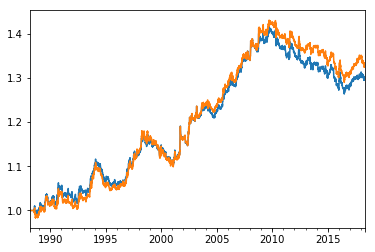

In [7]:
GRP_bt_test = GRP_bt('notional', RET, RB, min_vol, freq)
GRP_bt_test.ts_vol_control_backtest(TSRV)

(1. + GRP_bt_test.TSStrategy).cumprod().plot()
(1. + GRP_bt_test.TSStrategylag).cumprod().plot()

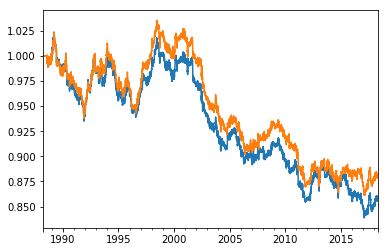

In [8]:
GRP_bt_test.cs_vol_control_backtest(CSRV)

(1. + GRP_bt_test.CSStrategy).cumprod().plot()
(1. + GRP_bt_test.CSStrategylag).cumprod().plot()

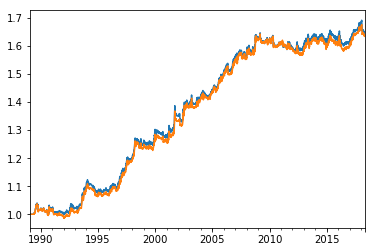

In [7]:
GRP_bt_test = GRP_bt('notional', RET, RB, min_vol, freq)
GRP_bt_test.ts_vol_control_backtest(TSRV)

(1. + GRP_bt_test.TSStrategy).cumprod().plot()
(1. + GRP_bt_test.TSStrategylag).cumprod().plot()

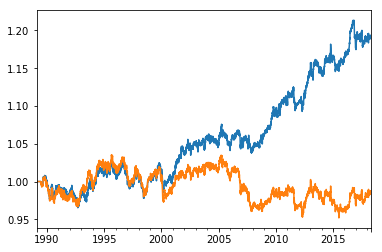

In [8]:
GRP_bt_test.cs_vol_control_backtest(CSRV)

(1. + GRP_bt_test.CSStrategy).cumprod().plot()
(1. + GRP_bt_test.CSStrategylag).cumprod().plot()

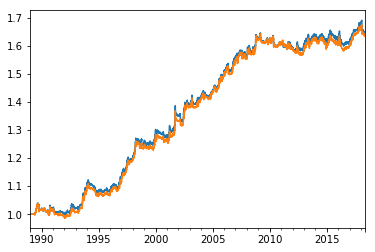

In [10]:
GRP_bt_test = GRP_bt('notional', RET, RB, min_vol, freq)
GRP_bt_test.ts_vol_control_backtest(TSRV)

(1. + GRP_bt_test.TSStrategy).cumprod().plot()
(1. + GRP_bt_test.TSStrategylag).cumprod().plot()

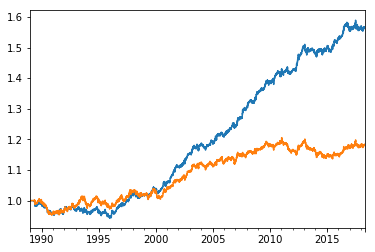

In [11]:
GRP_bt_test.cs_vol_control_backtest(CSRV)

(1. + GRP_bt_test.CSStrategy).cumprod().plot()
(1. + GRP_bt_test.CSStrategylag).cumprod().plot()

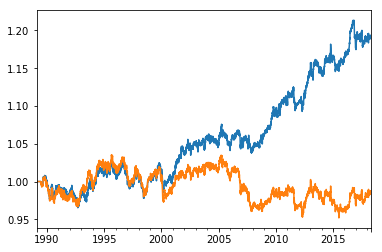

In [38]:
GRP_bt_test.cs_vol_control_backtest(CSRV)

(1. + GRP_bt_test.CSStrategy).cumprod().plot()
(1. + GRP_bt_test.CSStrategylag).cumprod().plot()

In [41]:
strat_name = 'IPM'

In [42]:
TS_dict[strat_name] = GRP_bt_test.TSStrategy
TS_dict_lag[strat_name] = GRP_bt_test.TSStrategylag
CS_dict[strat_name] = GRP_bt_test.CSStrategy
CS_dict_lag[strat_name] = GRP_bt_test.CSStrategylag

In [46]:
TS_dict_df = pd.DataFrame(TS_dict)
CS_dict_df = pd.DataFrame(CS_dict)

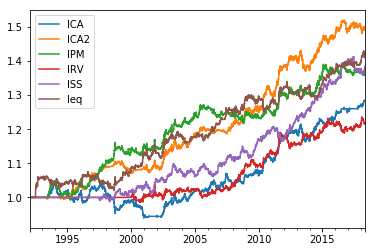

In [47]:
(1. + TS_dict_df.fillna(0)).cumprod().plot()

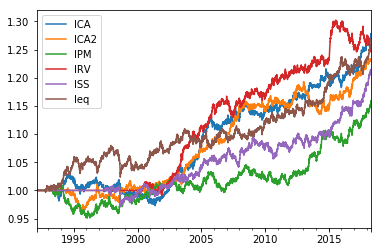

In [48]:
(1. + CS_dict_df.fillna(0)).cumprod().plot()

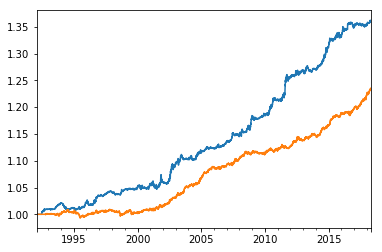

In [51]:
(1. + TS_dict_df.fillna(0).mean(axis=1)).cumprod().plot()
(1. + CS_dict_df.fillna(0).mean(axis=1)).cumprod().plot()

In [56]:
TS_dict_df.fillna(0).std() * np.sqrt(260)

ICA     0.019451
ICA2    0.018783
IPM     0.019949
IRV     0.017414
ISS     0.018439
Ieq     0.021684
dtype: float64

In [55]:
CS_dict_df.fillna(0).std() * np.sqrt(260)

ICA     0.020155
ICA2    0.019629
IPM     0.020044
IRV     0.017262
ISS     0.018493
Ieq     0.020446
dtype: float64

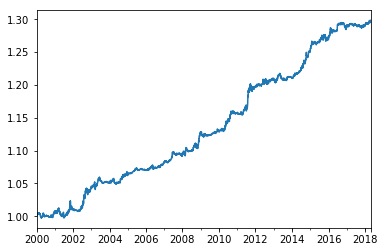

In [67]:
(1.+TS_dict_df.loc['2000':].mean(axis=1)).cumprod().plot()

In [68]:
(1.+TS_dict_df.loc['2000':].mean(axis=1)).cumprod().tail()

2018-05-03    1.298423
2018-05-04    1.298247
2018-05-07    1.298475
2018-05-08    1.298160
2018-05-09    1.298284
Freq: B, dtype: float64

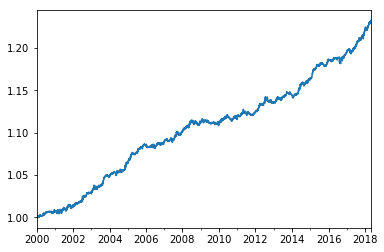

In [69]:
(1.+CS_dict_df.loc['2000':].mean(axis=1)).cumprod().plot()

In [70]:
(1.+CS_dict_df.loc['2000':].mean(axis=1)).cumprod().tail()

2018-05-03    1.232510
2018-05-04    1.232328
2018-05-07    1.232612
2018-05-08    1.232699
2018-05-09    1.232988
Freq: B, dtype: float64

In [63]:
TS_dict_df.loc['2000':].mean(axis=1).std() * np.sqrt(260)

0.011509770281469491

In [64]:
CS_dict_df.loc['2000':].mean(axis=1).std() * np.sqrt(260)

0.009136577023625473

## old ones,,

In [ ]:
def adjust_by_volband(df_vol, volband, weekday=1, min_vol=None):
    for i in range(1, len(df_vol.index)):
        if df_vol.iloc[i].name.weekday() == weekday:
            for c in range(len(df_vol.columns)):
                # case1. if new std is null
                if pd.isnull(df_vol.iloc[i, c]):
                    df_vol.iloc[i, c] = df_vol.iloc[i-1, c]
                # case2. if new std within volband
                if abs(df_vol.iloc[i, c] - df_vol.iloc[i-1, c]) < volband * df_vol.iloc[i-1, c] :
                    df_vol.iloc[i, c] = df_vol.iloc[i-1, c]
        else:
            df_vol.iloc[i] = df_vol.iloc[i-1]
    if min_vol is not None:
        df_vol[df_vol < min_vol] = min_vol

    return df_vol

In [33]:
# Param settings
CSLS = 'vol' # Cross Sectional Exposure Type. 'vol' means volatility allocation. 'notional' means notional. 

Assetvol = 0.02 # vol control parameter for individual assets
Strategyvol = 0.02 # vol control parameter for whole strategy
factorvol = 0.02
factorsd = 260 # lookback period for calcualting factorvol
assetsd = 90 # lookback period for calculating Assetvol
statsd = 90 # lookback period for calcualting Strategyvol

volband = 0.05 # if controled vol is within volband, do not change vol
min_vol = 0.15 # vol floor

In [34]:
# Calculating volatility for assets
std = (RET.rolling(window=assetsd).std() * np.sqrt(260)).iloc[assetsd:]

# Adjust calculated asset volatility
std_adj = adjust_by_volband(std.copy(), volband, min_vol=min_vol)

## Time Series

In [36]:
# Time Series 
VCweight = Assetvol / std_adj
VCTSpos = VCweight * TSRV # Vol Control Time Series Position
VCTSpos.replace([np.inf, -np.inf], np.nan, inplace=True)

# Strategy level vol control
# return of VC strategy
Strategy = (RET * VCTSpos.shift(1)).sum(axis=1)
# using average of expanding & moving window strategy risk
Strategyrisk_expanding = (Strategy.expanding(min_periods=statsd).std()*np.sqrt(260)).iloc[statsd:]
Strategyrisk_rolling = (Strategy.rolling(window=statsd).std()*np.sqrt(260)).iloc[statsd:]
Strategyrisk = (Strategyrisk_expanding + Strategyrisk_rolling) / 2.
# volband adjustment
bufrisk = adjust_by_volband(Strategyrisk.copy().to_frame(), volband)
# apply strategy level vol control to position
statlev = Strategyvol / bufrisk.iloc[:,0]
TSposition = VCTSpos.multiply(statlev, axis='index').iloc[statsd:]
TSposition.replace([np.inf, -np.inf], np.nan, inplace=True)
TSposition.fillna(0, inplace=True)

In [37]:
# calculate daily strategy return
TSStrategy = (RET * TSposition.shift(1)).sum(axis=1)
TSStrategylag = (RET * TSposition.shift(2)).sum(axis=1)

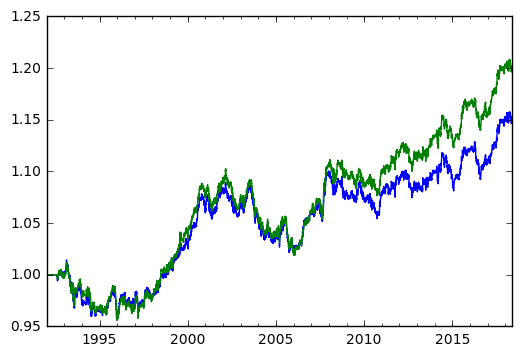

In [38]:
(1. + TSStrategy).cumprod().plot()
(1. + TSStrategylag).cumprod().plot()

## Cross Sectional

In [13]:
if CSLS == 'vol':
    CSRV = CSRV * Assetvol / std_adj

In [14]:
# Calculating Ex-ante Vol and adjust to target vol which specified by 'Strategyvol'
for i in range(len(CSRV.index)):
    if CSRV.iloc[i].name.weekday() == RB:
        CSRV.iloc[i] = CSRV.iloc[i] * Strategyvol / ex_ante_vol(RET, CSRV.iloc[i].name, CSRV.iloc[i])
    else:
        CSRV.iloc[i] = CSRV.iloc[i-1]

In [15]:
CSraw = (RET * CSRV.shift(1)).sum(axis=1)
CSrisk = (CSraw.rolling(window=statsd).std()*np.sqrt(260)).iloc[statsd:]

In [16]:
# volband adjustment
cs_bufrisk = adjust_by_volband(CSrisk.copy().to_frame(), volband)
# apply strategy level vol control to position
cs_statlev = Strategyvol / cs_bufrisk.iloc[:,0]
CSposition = CSRV.multiply(cs_statlev, axis='index').iloc[statsd:]
CSposition.replace([np.inf, -np.inf], np.nan, inplace=True)
CSposition.fillna(0, inplace=True)

In [17]:
# calculate daily strategy return
CSStrategy = (RET * CSposition.shift(1)).sum(axis=1)
CSStrategylag = (RET * CSposition.shift(2)).sum(axis=1)

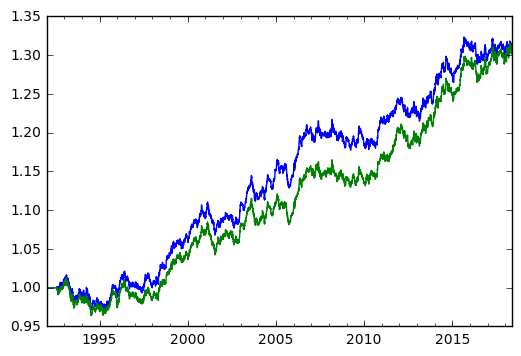

In [19]:
(1. + CSStrategy).cumprod().plot()
(1. + CSStrategylag).cumprod().plot()